In [ ]:
!gdown https://drive.google.com/uc?id=1rivfu2XULFbcnRFksJm2LOtir2lZQOV2 -O"Glof.csv"

Downloading...
From (original): https://drive.google.com/uc?id=1rivfu2XULFbcnRFksJm2LOtir2lZQOV2
From (redirected): https://drive.google.com/uc?id=1rivfu2XULFbcnRFksJm2LOtir2lZQOV2&confirm=t&uuid=f9f1d4fc-cdf1-4eb8-ac87-8aefa14286a0
To: /content/Glof.csv
100% 294M/294M [00:07<00:00, 41.4MB/s]


In [ ]:
import pandas as pd

In [ ]:
df= pd.read_csv("/content/Glof.csv")

In [ ]:
print(len(data))

2212863


In [ ]:
data.head()

,Latitude,Longitude,Snow_Albedo,snow_cover,Lake_bottom_temperature,total_precipitation,volumetric_soil,dew_point
0,-90.0,0.0,0.850002,100.0,277.130615,0.000062,0.2061,0.0
1,-90.0,0.1,0.850002,100.0,277.130615,0.000062,0.2061,0.0
2,-90.0,0.2,0.850002,100.0,277.130615,0.000062,0.2061,0.0
3,-90.0,0.3,0.850002,100.0,277.130615,0.000062,0.2061,0.0
4,-90.0,0.4,0.850002,100.0,277.130615,0.000062,0.2061,0.0


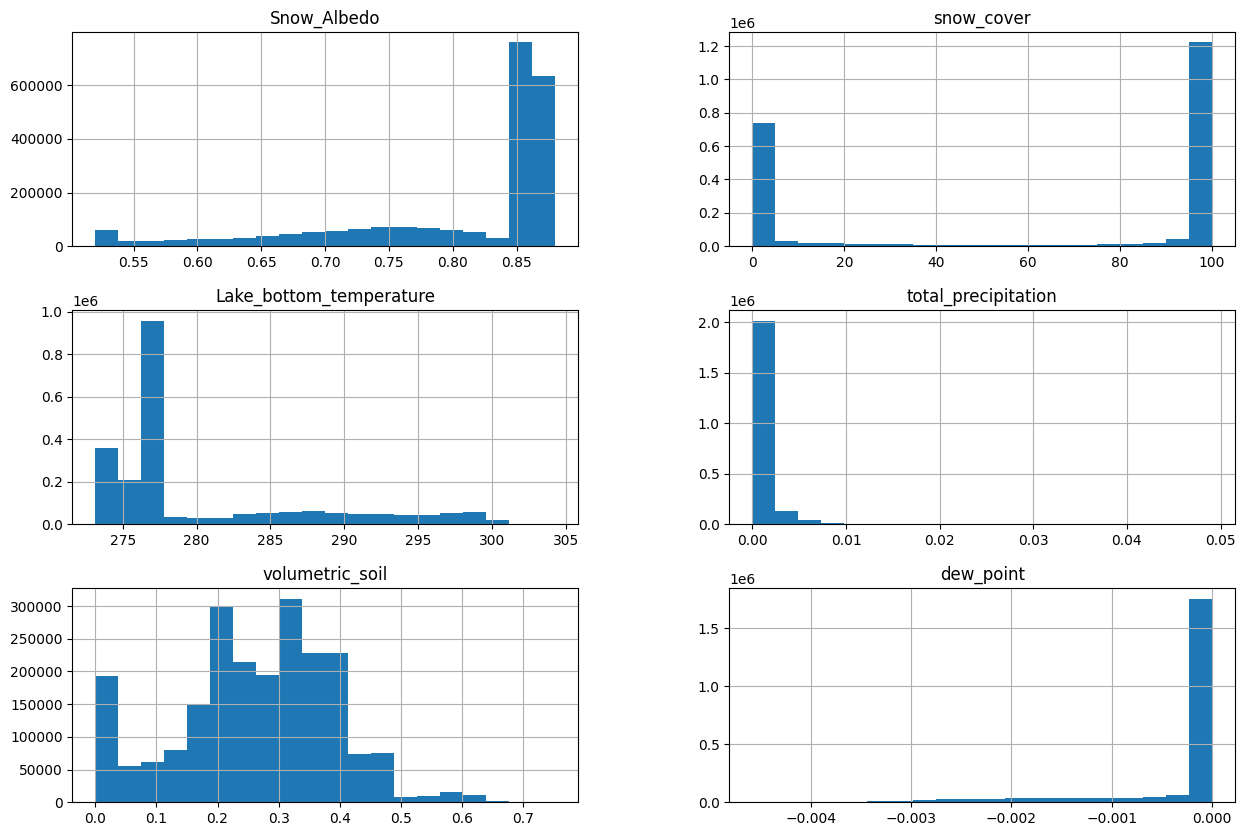

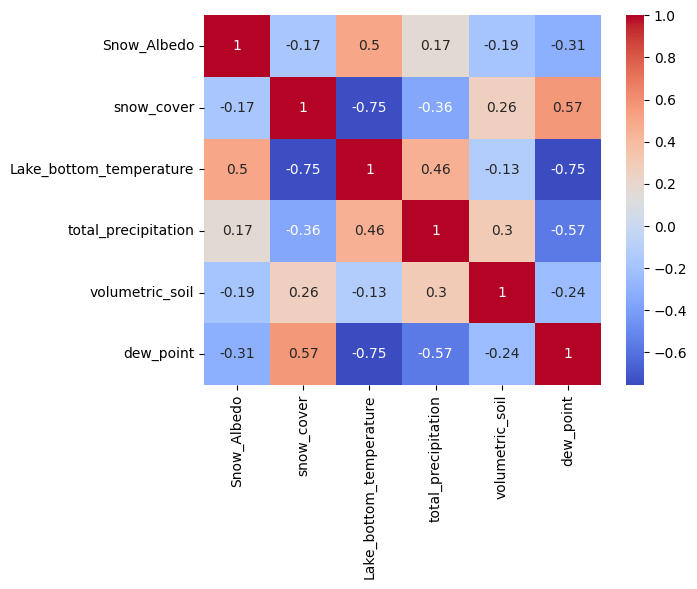

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histograms for each feature to analyze their distribution
features = ['Snow_Albedo',	'snow_cover',	'Lake_bottom_temperature',	'total_precipitation',	'volumetric_soil',	'dew_point']
df[features].hist(bins=20, figsize=(15,10))
plt.show()

# Correlation heatmap
corr = df[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


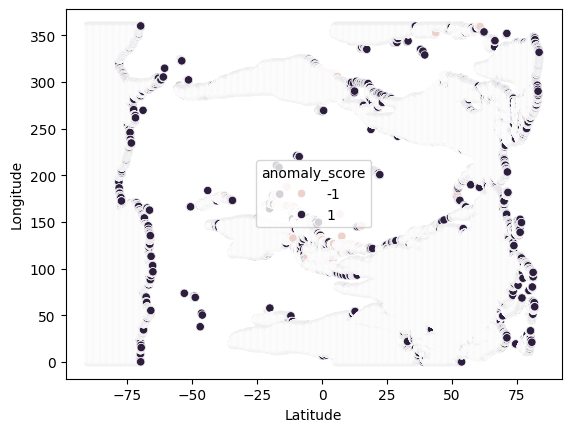

In [ ]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest model
iso_forest = IsolationForest(contamination=0.05)  # Assume 5% of the data is risky
df['anomaly_score'] = iso_forest.fit_predict(df[features])

# -1 represents anomalies (risky locations)
df_risky = df[df['anomaly_score'] == -1]
df_safe = df[df['anomaly_score'] == 1]

# Visualize risky vs. safe areas
sns.scatterplot(x='Latitude', y='Longitude', hue='anomaly_score', data=df)
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


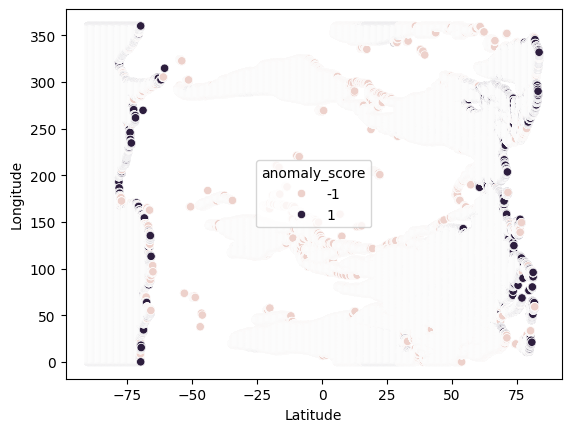

In [ ]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest model
iso_forest = IsolationForest(contamination=0.5)  # Assume 5% of the data is risky
df['anomaly_score'] = iso_forest.fit_predict(df[features])

# -1 represents anomalies (risky locations)
df_risky = df[df['anomaly_score'] == -1]
df_safe = df[df['anomaly_score'] == 1]

# Visualize risky vs. safe areas
sns.scatterplot(x='Latitude', y='Longitude', hue='anomaly_score', data=df)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


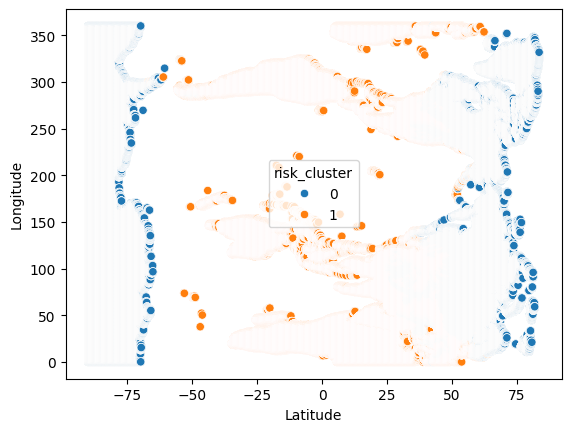

In [ ]:
from sklearn.cluster import KMeans

# Train a K-Means clustering model
kmeans = KMeans(n_clusters=2)  # Assume 2 clusters: Safe and Risky
clusters = kmeans.fit_predict(df[features])

# Add the cluster labels to the dataset
df['risk_cluster'] = clusters

# Analyze the clusters and determine which represents the risky group
sns.scatterplot(x='Latitude', y='Longitude', hue='risk_cluster', data=df)
plt.show()


In [ ]:
# Define X (features) and y (new labels: safe=0, risky=1)
X = df[features]
y = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)  # Risky=1, Safe=0

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train an XGBoost model
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01)
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_xgb = xgb_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99    221254
           1       0.99      0.99      0.99    221319

    accuracy                           0.99    442573
   macro avg       0.99      0.99      0.99    442573
weighted avg       0.99      0.99      0.99    442573



In [ ]:
# Required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
features = ['Snow_Albedo',	'snow_cover',	'Lake_bottom_temperature',	'total_precipitation',	'volumetric_soil',	'dew_point']
# Step 1: Initialize the Isolation Forest model
# The contamination parameter defines the proportion of the dataset that is considered an outlier.
iso_forest = IsolationForest(contamination=0.5, random_state=100)  # Assume 5% of data is risky

# Step 2: Prepare k-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=100)  # 5-fold cross-validation

# Placeholder to store accuracy for each fold
accuracies = []


In [ ]:
# Step 3: Perform k-Fold Cross-Validation
# We are iterating over each fold to train the model and test it
for train_index, test_index in kf.split(df):
    X_train, X_test = df.iloc[train_index][features], df.iloc[test_index][features]

In [ ]:
# Step 4: Fit the Isolation Forest model on the training data
iso_forest.fit(X_train)

IsolationForest(contamination=0.5, random_state=100)

In [ ]:
# Step 5: Predict anomalies (risky or safe) for the test data
# The output is 1 for 'normal' data points and -1 for 'anomalous' (risky) data points
y_pred_train = iso_forest.predict(X_train)
y_pred_test = iso_forest.predict(X_test)

In [ ]:
# Step 6: Evaluate accuracy for this fold
# Convert predictions (-1 = risky, 1 = safe) to binary format (risky = 1, safe = 0)
y_pred_test_binary = np.where(y_pred_test == -1, 1, 0)  # Risky = 1, Safe = 0
y_test_binary = np.where(iso_forest.predict(X_test) == -1, 1, 0)  # Actual target for testing fold

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_test_binary)
accuracies.append(accuracy)

# Output classification report for each fold
print(f"\nFold Classification Report:\n{classification_report(y_test_binary, y_pred_test_binary)}")


Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110247
           1       1.00      1.00      1.00    111039

    accuracy                           1.00    221286
   macro avg       1.00      1.00      1.00    221286
weighted avg       1.00      1.00      1.00    221286



In [ ]:
# Step 7: Average Accuracy over all folds
print(f"Average Cross-Validation Accuracy: {np.mean(accuracies)}")
# Step 8: Train on the entire dataset (after cross-validation)
iso_forest.fit(df[features])

Average Cross-Validation Accuracy: 1.0


IsolationForest(contamination=0.5, random_state=100)

In [ ]:
# Step 9: Predict for the entire dataset and create a 'safety_status' column
# Predict the final anomalies (1 = safe, -1 = risky)
df['anomaly_score'] = iso_forest.predict(df[features])

# Convert anomaly score to binary labels for 'safety_status' (risky = 1, safe = 0)
df['safety_status'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


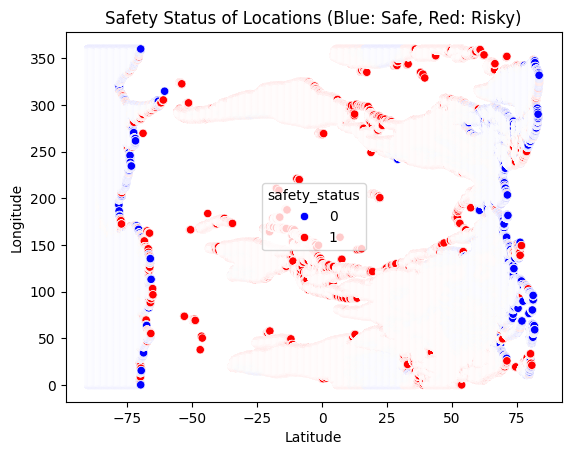

In [ ]:
# Step 10: Visualize Results (Optional)
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot to visualize latitude, longitude, and safety status
sns.scatterplot(x='Latitude', y='Longitude', hue='safety_status', data=df, palette={1: "red", 0: "blue"})
plt.title('Safety Status of Locations (Blue: Safe, Red: Risky)')
plt.show()

In [ ]:
# Step 11: Save the trained model for future use
import joblib

# Save the Isolation Forest model to a file
joblib.dump(iso_forest, 'glacial_lake_outburst_flood_model.pkl')

# To load the model in the future for prediction:
# loaded_model = joblib.load('glacial_lake_outburst_flood_model.pkl')


NameError: name 'iso_forest' is not defined

In [ ]:
# Step 12: Function to predict safety status on new data using the trained model

def predict_safety_status(new_data):
    # Assuming 'new_data' is a DataFrame with the same feature columns
    features = ['2m_dewpoint', 'snow_cover', 'snow_albedo', 'total_precipitation', 'volumetric_soil', 'lake_bottom_temperature']

    # Predict safety status using the loaded model
    predictions = iso_forest.predict(new_data[features])

    # Convert predictions to human-readable format
    new_data['safety_status'] = np.where(predictions == -1, 'risky', 'safe')

    return new_data

# Example new data (replace this with actual new data)
# new_data = pd.DataFrame({
#     '2m_dewpoint': [270.5, 280.1],
#     'snow_cover': [10.0, 5.0],
#     'snow_albedo': [0.7, 0.6],
#     'total_precipitation': [15.2, 9.1],
#     'volumetric_soil': [0.3, 0.45],
#     'lake_bottom_temperature': [278.1, 275.0],
#     'latitude': [27.5, 28.1],
#     'longitude': [85.2, 86.5]
# })

# Predict safety status for new data
# result = predict_safety_status(new_data)
# print(result)
